In [37]:
import numpy as np
import scipy.constants
import matplotlib
import matplotlib.pyplot as plt
import math
import os
import bisect
import pickle
import glob
import copy
import CDOconcat


plt.rcParams.update({'font.size': 16})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['image.cmap'] = 'inferno'
%matplotlib widget


def basic_1D(figsize=[6,4], ydata=[None], xdata=None, ylabel=None, xlabel=None, title=None, legendloc=None,
             yscale="linear", xscale="linear", drawstyle="default", colorlist=None, labels=None, linestyles=None,
             ymin=None, ymax=None, xmin=None, xmax=None, savename=None, suffix=None, plotfoldername=None, grid=True):
    
    fig = plt.figure(figsize=figsize)
    kwargs = {"drawstyle": drawstyle}

    for i, data in enumerate(ydata):
        if colorlist is not None:
            kwargs.update({"c": colorlist[i]})

        if labels is not None:
            kwargs.update({"label": labels[i]})
        
        if linestyles is not None:
            kwargs.update({"ls": linestyles[i]})

        plt.plot(xdata, data, **kwargs)

    axes = plt.gca()
    axes.set_yscale(yscale)
    axes.set_xscale(xscale)
    axes.set_ylim([ymin, ymax])
    axes.set_xlim([xmin, xmax])
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    if grid: axes.grid()
    if title is not None: plt.title(title)
    if legendloc is not None: plt.legend(loc=legendloc, fontsize="small", framealpha=0.5)
    
    if savename:
        if suffix is not None: savename += suffix
        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
    else:
        plt.show()


def twinx_1D(figsize=[6,4], ydata=[None], xdata=None, ylabel=None, xlabel=None, title=None, legendloc=None,
             yscale="linear", xscale="linear", drawstyle="default", colorlist=None, labels=None, linestyles=None,
             ymin=None, ymax=None, xmin=None, xmax=None, savename=None, plotfoldername=None, grid=True):
    
    fig = plt.figure(figsize=figsize)
    kwargs = {"drawstyle": drawstyle}

    for i, data in enumerate(ydata):
        if colorlist is not None:
            kwargs.update({"c": colorlist[i]})

        if labels is not None:
            kwargs.update({"label": labels[i]})
        
        if linestyles is not None:
            kwargs.update({"ls": linestyles[i]})

        plt.plot(xdata, data, **kwargs)

    axes = plt.gca()
    axes.set_yscale(yscale)
    axes.set_xscale(xscale)
    axes.set_ylim([ymin, ymax])
    axes.set_xlim([xmin, xmax])
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    if grid: axes.grid()
    if title is not None: plt.title(title)
    if legendloc is not None: plt.legend(loc=legendloc, fontsize="small", framealpha=0.5)
    
    if savename:
        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
    else:
        plt.show()


def basic_2D(data, figsize=[6,5], xgrid=None, ygrid=None, savename=None, 
             title=None, cbarlabel=None, plotfoldername=None, ymin=None, ymax=None,
             normalization="lin", linthresh=1e-2, xlabel=None, ylabel=None,
             datamin=None, datamax=None, logdiff=None, levels=None, cmap=None):

    if data.max() < 0 and datamax is None:
        print("Warning! Datamax < 0, switching to symlog")
        normalization = "symlog"
    
    data[data > 1e308] = 0
    data[data == float('+inf')] = 0
    
    if datamax is None:
        datamax = data.max()
    
    if datamin is None:
        datamin = data.min()

    if levels is None:
        levels = 11
        
    if cmap is None:
        cmap = plt.colormaps['inferno']
        
    fig = plt.figure(figsize=figsize)
    axes = plt.subplot(1, 1, 1)
    
    if normalization == "log":
        if logdiff is None:
            ld = math.log10(datamax) - 1
            if ld > 10:
                logdiff = ld
            else:
                logdiff = 10
        
        logmax = math.ceil(np.log10(datamax))
        logmin = logmax - logdiff
        numofticks = logdiff
        div = logdiff // numofticks
        power = np.arange((logmax - (numofticks * div)), logmax, div)
        array = np.zeros(len(power)) + 10.
        ticks = np.power(array, power)
        levels1 = np.logspace(logmin, logmax, levels, base=10.0)
        formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
        norm = matplotlib.colors.LogNorm(vmin=10 ** (logmin), vmax=datamax)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)
        cbar = plt.colorbar(ticks=ticks, format=formatter)
        cbar.formatter = matplotlib.ticker.LogFormatterExponent(base=10)
        cbar.update_ticks()
    elif normalization == "lin":
        levels2 = np.linspace(datamin, datamax, levels)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels2, cmap=cmap, vmin=datamin, vmax=datamax)
        cbar = plt.colorbar(plot)
    elif normalization == "symlog":
        norm = matplotlib.colors.SymLogNorm(linthresh=linthresh)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels, norm=norm, cmap=plt.colormaps['RdBu'], vmax=datamax, vmin=-datamax)
        cbar = plt.colorbar()

    axes = plt.gca()
    axes.set_facecolor('black')
    cbar.set_label(cbarlabel)
    axes.set_ylim(ymin, ymax)
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    axes.set_title(title)
    
    if savename:
        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
    

def calculate_indices(timegrid, start, ms_step):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames

    
def newest_output(path):
    list2 = glob.glob(path + 'output_??_.h5')
    if len(list2) > 0:
        return max( glob.glob(path + 'output_??_.h5'))
    else:
        return max( glob.glob(path + 'output_?_.h5'))


def calculate_index_array(timegrid, array):
    indices = np.zeros(len(array), dtype=np.intc)
    for i, j in enumerate(array):
        indices[i] = int(bisect.bisect_left(timegrid, j))
        
    return indices



TDK/  
- 2018_0Ar_0rec/  
- 2018_0Ar_6e24rec/  
- 2018_Ar_0rec/  
- 2018_lowres_diff30/  
- 2018_lowres_diff1000/  
- Ar_10ms_tr_off/  
- ref_VDE_8ms_10cm_6e24rec_diff1000/  
- VDE_0.1Ar/  
- VDE_1cm/  
- VDE_1ms/  
- VDE_2e24rec/  
- VDE_6e23rec/  
- VDE_20ms/  
- VDE_diff330/  
- VDE_diff3300/  

VDE/  
- lessCompton/ - gamma flux 1e10 - original 1e18  
- lessCompton2/ - gamma flux 1e15  
- kin_ava/ - pCutAvalanche - 2.5  
- kin_ava2/ - pCutAvalanche - 0.01  

In [33]:
parentfolder = "C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/"
# folder = parentfolder + "TDK/" + "VDE_2e24rec/"
folder = parentfolder + "VDE/lessCompton2/"
plt.close('all')

In [6]:
# read data
fnames = []
try:
    newest = newest_output(folder)
    print(newest)
    numoffiles = int(newest.split("_")[-2])
except:
    print("Finding newest output unsuccesful")
    
for i in range(1, numoffiles + 1):
    fname = folder + "output_" + str(i) + "_.h5"
    fnames.append(fname)
    
print(fnames)
concat = CDOconcat.CustomConcat(fnames)
endtime = '{0:.0f}'.format(concat.timegrid_ms[-1])
concat.info()


C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec\output_14_.h5
['C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_1_.h5', 'C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_2_.h5', 'C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_3_.h5', 'C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_4_.h5', 'C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_5_.h5', 'C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_6_.h5', 'C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_7_.h5', 'C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_8_.h5', 'C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_9_.h5', 'C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/TDK/VDE_2e24rec/output_10_.h5', 'C:/Users/lefer/Docum

kwargs_test = {("figsize": , "ydata": , "xdata": , "ylabel": , "xlabel": , 
                "title": , "yscale": , "xscale": , "drawstyle": , 
                "colorlist": , "labels": , "linestyles": ,
                "ymin": , "ymax": , "xmin": , "xmax": ,
                "savename": , "plotfoldername": , "grid": True)}


In [41]:
# color_list = plt.cm.inferno(np.linspace(0.9, 0, len(ydatalist_1D)))
# color_list = plt.cm.viridis(np.linspace(0.95, 0, len(ydatalist_1D)))
# "colorlist": color_list,

language = "EN HU notitle"  # "HU", "EN", "EN HU", "HU notitle", "EN notitle" or "EN HU notitle" 
figures = True
zoomed = True
zt = 150  # zoomed time will be the [0, zt] millisecond range
if (concat.I_re[-1] + concat.I_hot[-1]) > 2e5:
    distributions = True
else:
    distributions = False
    
if concat.density_Ar.size > 0: 
    argon = True 
else: 
    argon = False

EN_R = "Minor radius [m]"
EN_T = "Time [ms]"
F_EN = folder + "EN_" + endtime + "/"
F_EN_NT = folder + "EN_NT_" + endtime + "/"

HU_R = "Kissugár [m]"
HU_T = "Idő [ms]"
F_HU = folder + "HU_" + endtime + "/"
F_HU_NT = folder + "HU_NT_" + endtime + "/"

plotfoldernames = []
if "notitle" in language:
    if "EN" in language: plotfoldernames.append(F_EN_NT)
    if "HU" in language: plotfoldernames.append(F_HU_NT)
else:
    if "EN" in language: plotfoldernames.append(F_EN)
    if "HU" in language: plotfoldernames.append(F_HU)

for plotfoldername in plotfoldernames:
    if os.path.exists(plotfoldername):
        pass
    else:
        os.mkdir(plotfoldername)

for_1D_plotting = []
for_1D_twinx = []
for_2D_plotting = []

"""Currents 1D"""
if figures:
    ydatalist_1D = [concat.I_p / 1e6,
                    (concat.I_re + concat.I_hot) / 1e6, 
                    concat.I_wall / 1e6, 
                    concat.I_ohm / 1e6]
    
    kwargs1D = {"figsize": (6, 5), 
                "ydata": ydatalist_1D, 
                "ymin": 0, "ymax": None,
                "xdata": concat.timegrid_ms,
                "xmin": 0, "xmax": None, 
                "linestyles": ["-", "-", "-", "--"],
                "legendloc": "upper right",
                "savename": "0_currents", 
                "grid": True}
    
    if "EN" in language:
        kwargsEN = copy.deepcopy(kwargs1D)
        kwargsEN.update({"ylabel": EN_R,
                         "xlabel": EN_T,
                         "title": None,
                         "labels": [r"I$_p$", r"I$_{RE}$", r"I$_{wall}$", r"I$_{ohm}$"],
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargsEN.update({"title": None, "plotfoldername": F_EN_NT})
        for_1D_plotting.append(kwargsEN)
        if zoomed:
            zoomedEN = copy.deepcopy(kwargsEN)
            zoomedEN.update({"xmax": zt, "suffix": "_" + str(zt)})
            for_1D_plotting.append(zoomedEN)
    
    if "HU" in language:
        kwargsHU = copy.deepcopy(kwargs1D)
        kwargsHU.update({"ylabel": HU_R,
                         "xlabel": HU_T,
                         "title": None,
                         "labels": [r"I$_p$", r"I$_{elfutó}$", r"I$_{fal}$", r"I$_{ohm}$"],
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargsHU.update({"title": None, "plotfoldername": F_HU_NT})
        for_1D_plotting.append(kwargsHU)
        if zoomed:
            zoomedHU = copy.deepcopy(kwargsHU)
            zoomedHU.update({"xmax": zt, "suffix": "_" + str(zt)})
            for_1D_plotting.append(zoomedHU)
    

"""Temperature 2D"""
if 0:
    kwargs2D = {"figsize": (6, 5), 
                "data": concat.T_cold, 
                "datamin": None, "datamax": None,
                "ygrid": concat.timegrid_ms,
                "ymin": 0, "ymax": None,
                "xgrid": concat.radialgrid, 
                "ylabel": 'Electron temperature',
                "xlabel": 'Time [ms]',
                "cbarlabel": r"log$_{10}$(T$_{cold}$/(1eV)) [-]",
                "title": None, 
                "normalization": "log",
                "logdiff": 5, "levels": 16,
                "cmap": None,
                "linthresh": None,
                "savename": None, 
                "plotfoldername": plotfoldername}
    for_2D_plotting.append(kwargs2D)

for kwargs in for_1D_plotting:
    basic_1D(**kwargs)
for kwargs in for_2D_plotting:
    basic_2D(**kwargs)
    

In [ ]:
# Áramok
fig = plt.figure(figsize=(8, 6))
plt.subplot(1, 1, 1)  # rows, columns, index

plt.plot(concat.timegrid_ms, concat.I_p / 1e6, label=r"I$_p$")
plt.plot(concat.timegrid_ms, (concat.I_re + concat.I_hot) / 1e6, label=r"I$_{RE}$")
plt.plot(concat.timegrid_ms, concat.I_wall / 1e6, label=r"I$_{wall}$")
plt.plot(concat.timegrid_ms,  concat.I_ohm / 1e6, linestyle="--", label=r"I$_{ohm}$")

plt.ylabel('Currents [MA]')
plt.xlabel('Time [ms]')
plt.tick_params('x', labelbottom=True)

plt.ylim(0, 18)
plt.legend()
plt.grid()

plt.show()

In [11]:
# times list in milliseconds
times = [10, 20, 50, 100, 200, 400, 600, 700, 800, 945]
times2 =[750, 800, 850, 900, 945]


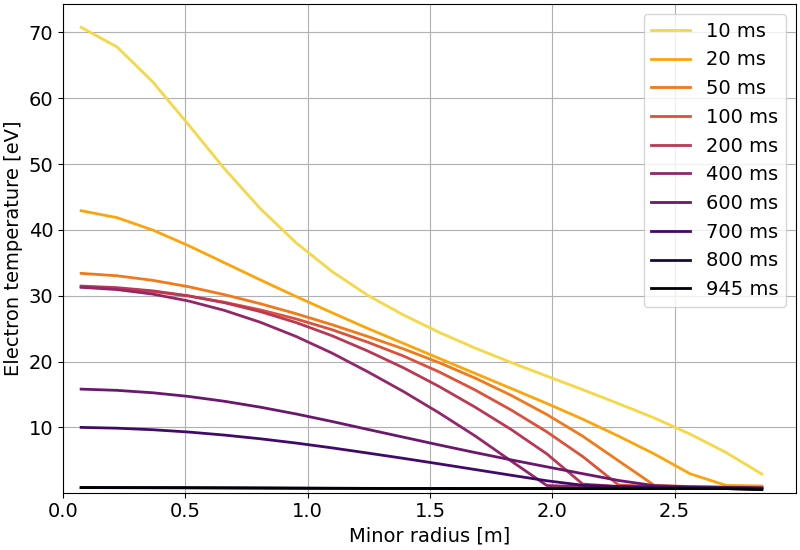

In [12]:
# 1D elektronhőmérséklet
indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times)
ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))

xdata = concat.radialgrid
ydata = concat.T_cold
fig = plt.figure(figsize=(8, 5.5))
ax = plt.subplot(1, 1, 1)  # rows, columns, index
# ax.set_facecolor("lightblue")
for j, i in enumerate(indices):
    plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])

plt.ylabel(r'Electron temperature [eV]')
plt.xlabel(r'Minor radius [m]')
plt.tick_params('x', labelbottom=True)

plt.ylim(1e-1, None)
plt.xlim(0, None)
#plt.yscale("log")
plt.legend()
plt.grid()
if 1:
    plt.show()

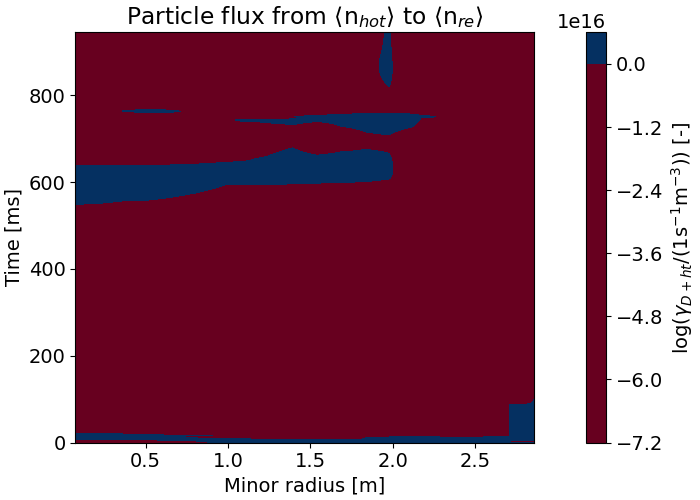

In [13]:
# "gamma_D_ht"
basic_2D(figsize=[7,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
        title=r"Particle flux from $\langle$n$_{hot}\rangle$ to $\langle$n$_{re}\rangle$", 
        cbarlabel=r"log($\gamma_{D+ht}$/(1s$^{-1}$m$^{-3}$)) [-]", 
        plotfoldername=plotfoldername, ymin=0, ymax=None,
        normalization="symlog", linthresh=5e15, data=concat.flux_to_RE, 
        xlabel="Minor radius [m]", ylabel="Time [ms]",
        cmap=plt.colormaps['seismic'])

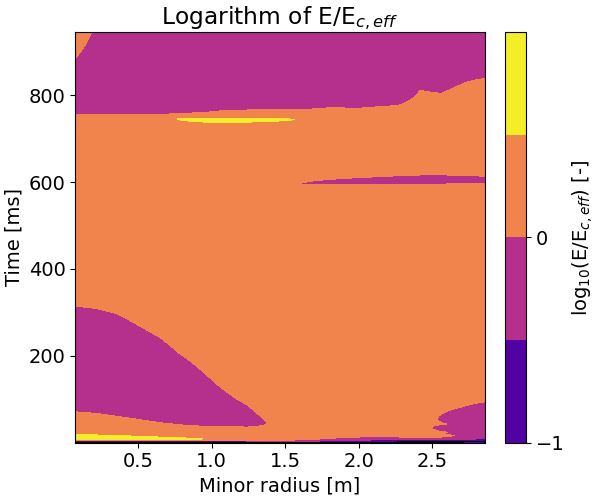

In [14]:
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title=r"Logarithm of E/E$_{c, eff}$", cbarlabel=r"log$_{10}$(E/E$_{c, eff}$) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.E_field/concat.Eceff, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=2, levels=5, cmap=plt.colormaps['plasma'])

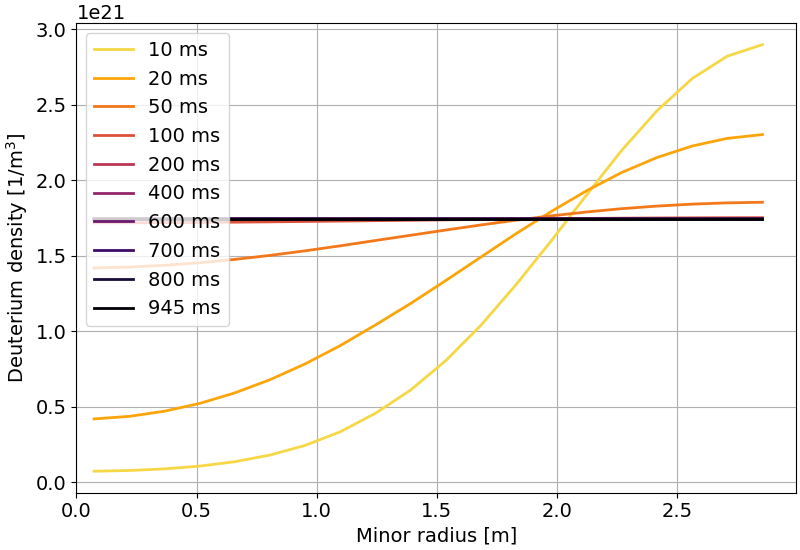

In [16]:
# Teljes deut sűrűség 1D line
indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times)
ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))

xdata = concat.radialgrid
ydata = density_D_0 + density_D_1
fig = plt.figure(figsize=(8, 5.5))
ax = plt.subplot(1, 1, 1)  # rows, columns, index
# ax.set_facecolor("lightblue")
for j, i in enumerate(indices):
    plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])

plt.ylabel(r'Deuterium density [1/m$^3$]')
plt.xlabel(r'Minor radius [m]')
plt.tick_params('x', labelbottom=True)

plt.ylim(None, None)
plt.xlim(0, None)
#plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

In [17]:
figures = True
distributions = 1
if density_Ar.size > 0: 
    argon = True 
else: 
    argon = False

# Deut teljes sűrűség 1D line
if figures:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times)
    ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = density_D_0 + density_D_1
    fig = plt.figure(figsize=(8, 5.5))
    ax = plt.subplot(1, 1, 1)  # rows, columns, index
    # ax.set_facecolor("lightblue")
    for j, i in enumerate(indices):
        plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])

    plt.ylabel(r'Deuterium density [1/m$^3$]')
    plt.xlabel(r'Minor radius [m]')
    plt.tick_params('x', labelbottom=True)

    plt.ylim(None, None)
    plt.xlim(0, None)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    savename = "Deut_LINE_"
    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# T_cold LINE plot
if figures:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times)
    ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.T_cold
    fig = plt.figure(figsize=(8, 5.5))
    ax = plt.subplot(1, 1, 1)  # rows, columns, index
    # ax.set_facecolor("lightblue")
    for j, i in enumerate(indices):
        plt.plot(xdata, ydata[i, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", c=ccolors[j])

    plt.ylabel(r'Electron temperature [eV]')
    plt.xlabel(r'Minor radius [m]')
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e-1, None)
    plt.xlim(0, None)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    savename = "T_cold_LINE_"
    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
# Deut sűrűségek
if figures:
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z0", 
             title="Z=0 Deuterium density", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=density_D_0, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    # basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z0_zoom", 
    #          title="Z=0 Deuterium density", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
    #          plotfoldername=plotfoldername, ymax=150,
    #          normalization="log", data=density_D_0, xlabel="Minor radius [m]", ylabel="Time [ms]",
    #          datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z1", 
             title="Z=1 Deuterium density", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=density_D_1, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    # basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z1_zoom", 
    #          title="Z=1 Deuterium density", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
    #          plotfoldername=plotfoldername, ymax=150,
    #          normalization="log", data=density_D_1, xlabel="Minor radius [m]", ylabel="Time [ms]",
    #          datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_total", 
             title="Total Deuterium density", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=density_D_0 + density_D_1, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)

# 2D current densityek
if figures:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_tot", 
             title="Total current density", cbarlabel=r"log$_{10}$(j$_{tot}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_tot, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_re", 
             title="RE current density", cbarlabel=r"log$_{10}$(j$_{RE}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_re, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_ohm", 
             title="Ohmic current density", cbarlabel=r"log$_{10}$(j$_{ohm}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_ohm, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)

# T_cold, E_field lin, E_c,eff
if figures:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="T_cold_full", 
             title="Electron temperature", cbarlabel=r"log$_{10}$(T$_{cold}$/(1eV)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.T_cold, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=5, levels=16)
    # basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="T_cold_zoomed", 
    #          title="Electron temperature", cbarlabel=r"log$_{10}$(T$_{cold}$/(1eV)) [-]", 
    #          plotfoldername=plotfoldername, ymax=150,
    #          normalization="log", data=concat.T_cold, xlabel="Minor radius [m]", ylabel="Time [ms]",
    #          datamin=None, datamax=None, logdiff=5, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="E_field_lin", 
             title="Electric field", cbarlabel=r"E [V/m]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="lin", data=concat.E_field, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="log_ratio_E_to_Eceff", 
             title=r"Logarithm of E/E$_{c, eff}$", cbarlabel=r"log$_{10}$(E/E$_{c, eff}$) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.E_field/concat.Eceff, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=2, levels=5, cmap=plt.colormaps['plasma'])

# currents    
if figures:
    fig = plt.figure(figsize=(8, 6))
    plt.subplot(1, 1, 1)  # rows, columns, index
    # For example fig.add_subplot(3, 1, (1, 2)) makes a subplot that spans the upper 2/3 of the figure

    plt.plot(concat.timegrid_ms, concat.I_p / 1e6, label=r"I$_p$")
    plt.plot(concat.timegrid_ms, (concat.I_re + concat.I_hot) / 1e6, label=r"I$_{RE}$")
    plt.plot(concat.timegrid_ms, concat.I_wall / 1e6, label=r"I$_{wall}$")
    plt.plot(concat.timegrid_ms,  concat.I_ohm / 1e6, linestyle="--", label=r"I$_{ohm}$")
    plt.plot(concat.timegrid_ms,  concat.I_hot / 1e6, label=r"I$_{hot}$")

    plt.ylabel('Currents [MA]')
    plt.xlabel('Time [ms]')
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, 18)
    plt.legend()
    plt.grid()

    savename = "currents_"
    savename += "REgrid_" + str(concat.runawaygrid_dimensions) + "_pMax_" 
    savename += '{0:.0f}'.format(np.round(concat.re_momentumgrid_edges[-1], 0))

    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# f_re - multiple
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times2)
    ccolors = plt.cm.viridis(np.linspace(0.9, 0, len(indices)))

    xdata = concat.re_momentumgrid
    
    for r in [0, 5, 10, 15, 19]:
        ydata = concat.f_re_avg[:, r]
        fig = plt.figure(figsize=(8, 5))
        plt.subplot(1, 1, 1)  # rows, columns, index
        
        for j, i in enumerate(indices):
            plt.plot(xdata, ydata[i], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", c=ccolors[j])

        plt.ylabel(r'f$_{RE}$  [m$^{-3}$]')
        plt.xlabel(r'p$_{||}$')
        plt.tick_params('x', labelbottom=True)

        plt.ylim(1e7, 1e14)
        plt.yscale("log")
        plt.legend()
        plt.grid()


        savename = ("f_re_avg_REgrid_" + str(concat.runawaygrid_dimensions) 
                    +"_r_" + '{0:.3f}'.format(np.round(concat.radialgrid[r], 3)) + "m")
        while os.path.exists(plotfoldername + savename + ".png"):
            savename += "_alt"

        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)

# n_re     
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times2)
    ccolors = plt.cm.viridis(np.linspace(0.9, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.n_re
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", color=ccolors[j])
        j += 1

    plt.ylabel(r'RE particle density [m$^{-3}$]')
    plt.xlabel(r'Minor radius [m]')
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e14, None)
    plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = ("n_RE_REgrid_" + str(concat.runawaygrid_dimensions))
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# j_re   
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times2)
    ccolors = plt.cm.viridis(np.linspace(0.9, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.j_re
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", c=ccolors[j])
        j += 1

    plt.ylabel(r'RE current density [A/m$^{2}$]')
    plt.xlabel(r'Minor radius [m]')
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e4, None)
    plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = ("j_re_REgrid_" + str(concat.runawaygrid_dimensions))
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# j_tot  
if figures:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=times)
    ccolors = plt.cm.inferno(np.linspace(0.9, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.j_tot
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", color=ccolors[j])
        j += 1

    plt.ylabel(r'Total current density [A/m$^{2}$]')
    plt.xlabel(r'Minor radius [m]')
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e4, None)
    plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = ("j_tot_REgrid_" + str(concat.runawaygrid_dimensions))
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)

# Argon ionizációfok 
if argon:
    g_time = len(concat.timegrid)
    g_r = len(concat.radialgrid)
    avg_Ar_ionization = np.zeros((g_time, g_r))

    temp1 = 0  # weighted sum
    temp2 = 0  # simple sum of all argon atoms

    for i in range(g_time):
        for j in range(19):
            temp1 += j * density_Ar[i, j, :] * concat.real_volumes_of_cells
            temp2 += density_Ar[i, j, :] * concat.real_volumes_of_cells

        avg_Ar_ionization[i] = temp1 / temp2
    
    basic_2D(figsize=[7,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Ar_avg_Z", 
             title="Average ionization level of Ar", cbarlabel=r"Z$_{avg}$(Ar)", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="lin", data=avg_Ar_ionization, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, levels=18, cmap=plt.colormaps['plasma'])

# keletkezési ráták
if figures:
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="gamma_Dreicer", 
             title="Dreicer generation rate", cbarlabel=r"log$_{10}$($\gamma_{Dreicer}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaDreicer, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=5, levels=16, cmap=plt.colormaps['viridis'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="gamma_Compton", 
             title="Compton generation rate", cbarlabel=r"log$_{10}$($\gamma_{Compton}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaCompton, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17, cmap=plt.colormaps['viridis'])
    # basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="gamma_Tritium", 
    #          title="Tritium generation rate", cbarlabel=r"log$_{10}$($\gamma_{T}$/(s$^{-1}$m$^{-3}$)) [-]", 
    #          plotfoldername=plotfoldername, ymin=0, ymax=None,
    #          normalization="log", data=concat.gammaTritium, xlabel="Minor radius [m]", ylabel="Time [ms]",
    #          datamin=None, datamax=None, logdiff=4, levels=17, cmap=plt.colormaps['plasma'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="gamma_Ava", 
             title="Avalanche generation rate", cbarlabel=r"log$_{10}$($\gamma_{ava}$/(s$^{-1}$m$^{-3}$)) [-]", 
             plotfoldername=plotfoldername, ymin=0, ymax=None,
             normalization="log", data=concat.gammaAva * concat.n_re, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=13, levels=27, cmap=plt.colormaps['viridis'])
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="fre_coll_pow_dens", 
             title="RE collisional\npower density", cbarlabel=r"PD$_{coll}$ [MWm$^{-3}$]", 
             plotfoldername=plotfoldername, ymin=None, ymax=None,
             normalization="lin", linthresh=1e-2, data=abs(concat.Tcold_fre_coll) / 1e6, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=None, levels=119, cmap=plt.colormaps['plasma'])
        


C:\Users\lefer\AppData\Local\Temp\ipykernel_12332\2367900788.py:85: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)


In [18]:
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="W_cold", 
         title="Cold electron energy density", cbarlabel=r"log$_{10}$(W$_{cold}$/(J/m$^3$)) [-]", 
         plotfoldername=plotfoldername, ymax=None,
         normalization="log", data=concat.W_cold, xlabel=None, ylabel=None,
         datamin=None, datamax=None, logdiff=5, levels=16)
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_ohmic", 
         title="Ohmic power density", cbarlabel=r"log$_{10}$(PD$_{ohm}$/(W/m$^3$)) [-]", 
         plotfoldername=plotfoldername, ymax=None,
         normalization="log", data=-concat.Tcold_ohmic, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=1e8, logdiff=5, levels=16)
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_rad", 
         title="Radiated power density", cbarlabel=r"log$_{10}$(PD$_{rad}$/(W/m$^3$)) [-]", 
         plotfoldername=plotfoldername, ymax=None,
         normalization="log", data=concat.Tcold_radiation, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=1e8, logdiff=5, levels=16)
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_transport", 
         title="Transported power density", cbarlabel=r"log$_{10}$(PD$_{tr}$/(W/m$^3$)) [-]", 
         plotfoldername=plotfoldername, ymax=None,
         normalization="log", data=concat.Tcold_transport, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=1e8, logdiff=5, levels=11)
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="Tcold_transport_neg", 
         title="Negative transported power density", cbarlabel=r"log$_{10}$(-PD$_{tr}$/(W/m$^3$)) [-]", 
         plotfoldername=plotfoldername, ymax=None, cmap=plt.colormaps['viridis'],
         normalization="log", data=-concat.Tcold_transport, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=1e8, logdiff=5, levels=11, linthresh=1e9)

C:\Users\lefer\AppData\Local\Temp\ipykernel_12332\2367900788.py:85: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)


C:\Users\lefer\AppData\Local\Temp\ipykernel_12332\2367900788.py:85: UserWarning: Log scale: values of z <= 0 have been masked
  plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)


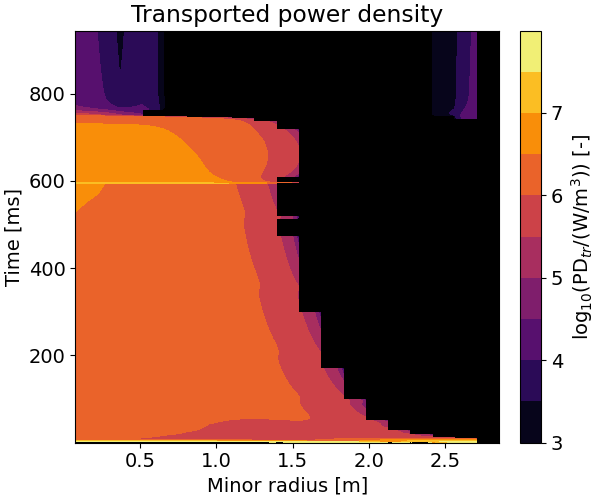

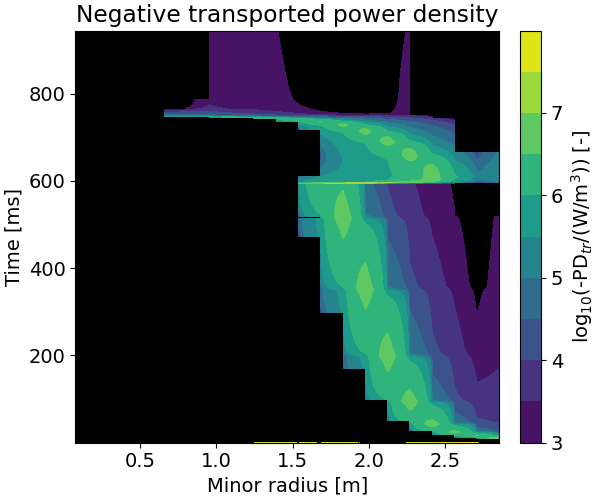

In [19]:
# "PDtr_pos" "PDtr_neg"
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
         title="Transported power density", cbarlabel=r"log$_{10}$(PD$_{tr}$/(W/m$^3$)) [-]", 
         plotfoldername=plotfoldername, ymax=None,
         normalization="log", data=concat.Tcold_transport, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=1e8, logdiff=5, levels=11, linthresh=1e9)
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
         title="Negative transported power density", cbarlabel=r"log$_{10}$(-PD$_{tr}$/(W/m$^3$)) [-]", 
         plotfoldername=plotfoldername, ymax=None, cmap=plt.colormaps['viridis'],
         normalization="log", data=-concat.Tcold_transport, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=1e8, logdiff=5, levels=11, linthresh=1e9)

In [ ]:
wall_radius = 2.96
wall_region_thickness = 0.1
wall_resistivity = 0.76e-6  # Ohm*m
walltime = scipy.constants.mu_0 * wall_radius * wall_region_thickness / wall_resistivity

print(str(np.round(walltime * 1000, 1)) + " ms")

489.4 ms
